#  **Heart Disease Prediction**
#
# **What this notebook contains (high-level)**
- Problem statement and dataset loading
- Exploratory Data Analysis (EDA)
- Preprocessing with reusable `Pipeline` and `ColumnTransformer`
- Model training & comparison (LogisticRegression, RandomForest, optionally XGBoost)
- Robust evaluation: Stratified K-Fold CV, ROC/AUC, Precision/Recall, Confusion Matrix
- Model interpretation: SHAP (global + local explanations) and feature importance
- Calibration check, saved artifacts, and concise conclusion + next steps
#


#  1) Environment & imports

In [ ]:
import os
import sys
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# Basic data + ML
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
    classification_report, average_precision_score
)

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Utilities
import joblib

print("Libraries loaded")

Libraries loaded


# 2) Load data

In [ ]:
possible_paths = [
    '/mnt/data/heart.csv',
    '/mnt/data/Heart.csv',
    '/mnt/data/heart_disease.csv',
    'heart.csv',
    'Heart.csv',
    'heart_disease.csv'
]

data_path = None
for p in possible_paths:
    if Path(p).exists():
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError(
        "Could not find dataset automatically. Please set `data_path` to your CSV file path (e.g. '/mnt/data/heart.csv')."
    )

print(f"Loading dataset from: {data_path}")

data = pd.read_csv(data_path)

print("Dataset loaded. Shape:", data.shape)

Loading dataset from: heart.csv
Dataset loaded. Shape: (303, 14)


#  Quick peek at the dataset


In [ ]:
# Show top rows and basic info
pd.set_option('display.max_columns', None)
print(data.head())
print('\nInfo:')
print(data.info())
print('\nMissing values per column:')
print(data.isna().sum())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int6

# 3) Quick EDA

In [ ]:
# Target column detection: try common names
possible_target_cols = ['target', 'diagnosis', 'heart_disease', 'disease', 'output']

target_col = None
for c in possible_target_cols:
    if c in data.columns:
        target_col = c
        break

# If not found, assume last column is target (common in UCI csvs)
if target_col is None:
    target_col = data.columns[-1]

print(f"Using '{target_col}' as the target column")

# Convert target to integer 0/1 if possible
if not pd.api.types.is_integer_dtype(data[target_col]):
    data[target_col] = data[target_col].astype(int)

Using 'target' as the target column



Class distribution:
target
1    0.544554
0    0.455446
Name: proportion, dtype: float64


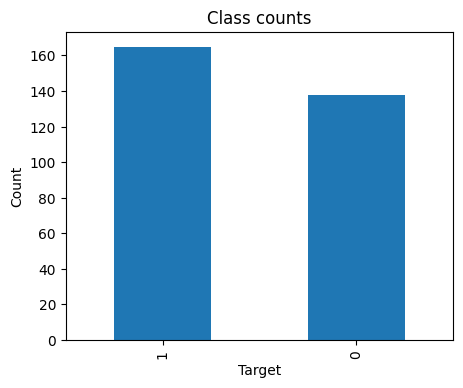

In [ ]:
# Convert target to integer 0/1 if possible
if not pd.api.types.is_integer_dtype(data[target_col]):
    data[target_col] = data[target_col].astype(int)

# Class balance
print('\nClass distribution:')
print(data[target_col].value_counts(normalize=True).rename('proportion'))

# Plot class balance
plt.figure(figsize=(5,4))
data[target_col].value_counts().plot(kind='bar')
plt.title('Class counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


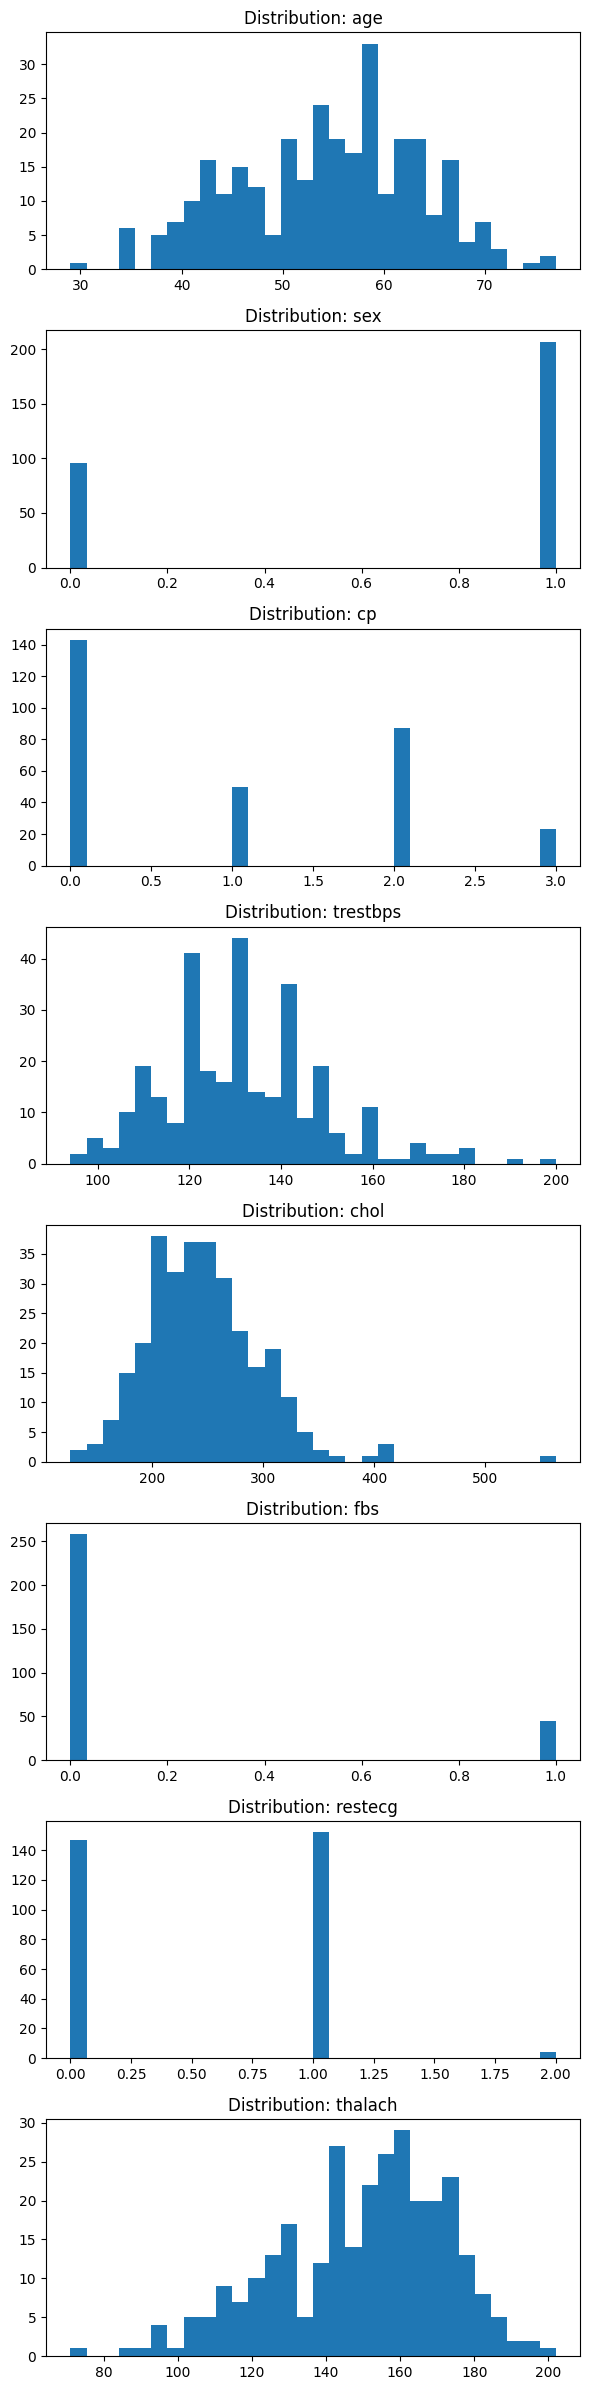

In [ ]:
# Numeric feature distributions: show histogram for top numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

print('\nNumeric columns:', numeric_cols)

# Show histograms for up to 8 numeric cols
n_to_plot = min(len(numeric_cols), 8)
plt.style.use('default')
fig, axes = plt.subplots(n_to_plot, 1, figsize=(6, 3*n_to_plot))
for i, col in enumerate(numeric_cols[:n_to_plot]):
    ax = axes[i]
    ax.hist(data[col].dropna(), bins=30)
    ax.set_title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

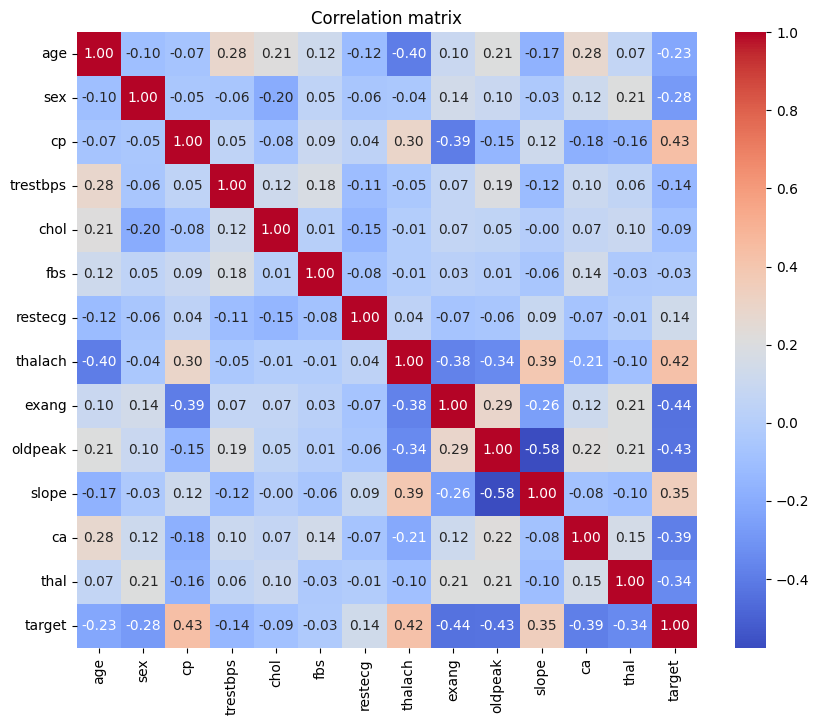

In [ ]:
# Correlation heatmap (numeric features)
try:
    import seaborn as sns
    plt.figure(figsize=(10,8))
    sns.heatmap(data[numeric_cols + [target_col]].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation matrix')
    plt.show()
except Exception:
    print('Seaborn not available — skipping heatmap')


 # 4) Train / Test split

In [ ]:
X = data.drop(columns=[target_col])
y = data[target_col]

# Stratified split to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (242, 13) Test shape: (61, 13)


# 5) Preprocessing pipeline (robust, reproducible)

In [ ]:
# Heuristic: treat object/ category dtype and low unique-count numeric columns as categorical
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


In [ ]:
# Treat low-cardinality numeric columns (<= 10 unique) as categorical (e.g., 'cp', 'thal')
for c in num_cols.copy():
    if X[c].nunique() <= 10:
        cat_cols.append(c)
        num_cols.remove(c)

print('Numeric columns used:', num_cols)
print('Categorical columns used:', cat_cols)

Numeric columns used: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical columns used: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [ ]:
# Build transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# 6) Model training: baseline and comparison

In [ ]:
# Create pipelines for each model so the entire process is reproducible
pipelines = {
    'logreg': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000, random_state=42))]),
    'rf': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))])
}


In [ ]:
# Try adding XGBoost if available
try:
    from xgboost import XGBClassifier
    pipelines['xgb'] = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])
    print('XGBoost available — added to model list')
except Exception:
    print('XGBoost not installed — skipping')

XGBoost available — added to model list


In [ ]:
# Quick cross-validated comparison (ROC AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc')
    cv_results[name] = scores
    print(f"{name}: mean ROC AUC = {scores.mean():.4f} ± {scores.std():.4f}")


logreg: mean ROC AUC = 0.8904 ± 0.0355
rf: mean ROC AUC = 0.8846 ± 0.0621
xgb: mean ROC AUC = 0.8715 ± 0.0518



# (Optional) Hyperparameter Tuning with GridSearchCV
- To Demonstrate how to tune a RandomForest using a small grid.
.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42))])

grid_search = GridSearchCV(
    rf_pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV ROC AUC:", grid_search.best_score_)

# Update best model if needed
best_pipe = grid_search.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best CV ROC AUC: 0.9082036582036582


# 7) Fit best model on full training set and evaluate on test set

In [ ]:
# Choose best model by mean CV AUC
best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
print('Best model by CV AUC:', best_model_name)

best_pipe = pipelines[best_model_name]
best_pipe.fit(X_train, y_train)

Best model by CV AUC: logreg


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:
# Test set predictions
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print('\nTest set metrics:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Test set metrics:
Accuracy: 0.8688524590163934
Precision: 0.8571428571428571
Recall: 0.9090909090909091
F1: 0.8823529411764706
ROC AUC: 0.9101731601731602

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.86      0.91      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



# Confusion matrix

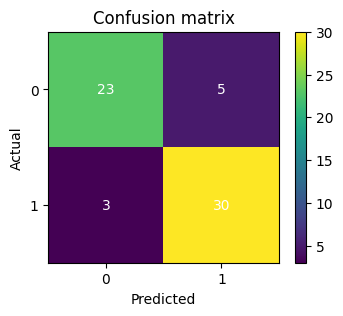

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks([0,1])
plt.yticks([0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

# ROC curve

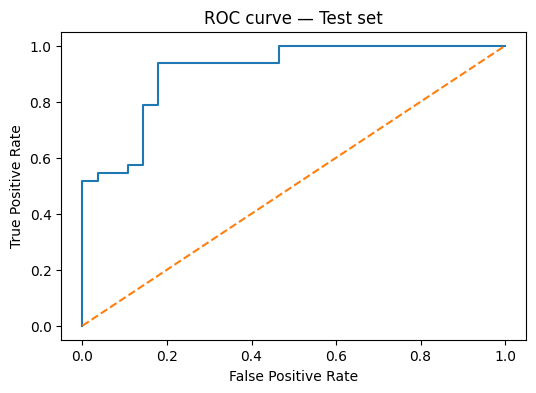

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve — Test set')
plt.show()

# Precision-Recall curve

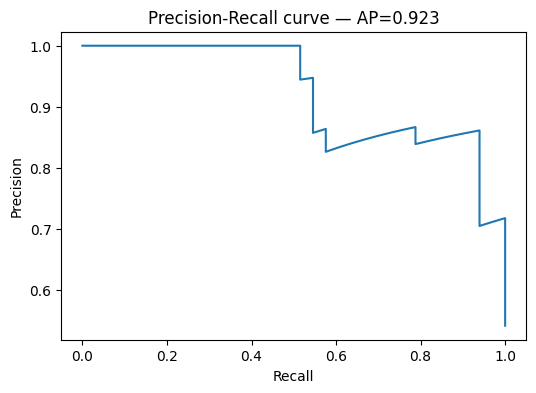

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve — AP={avg_prec:.3f}')
plt.show()

#  8) Calibration check (optional but useful in healthcare contexts)

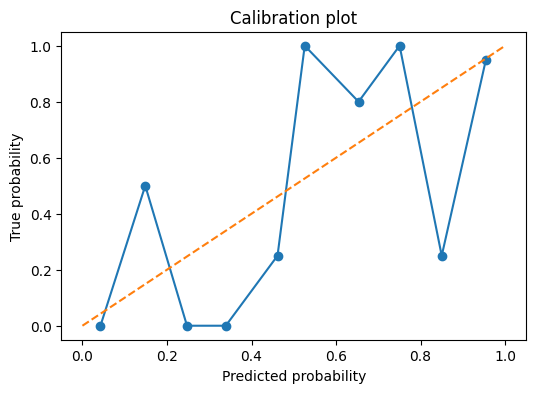

In [ ]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plot')
plt.show()

# 9) Feature importance & Explainability (SHAP)

In [ ]:
# We'll try to use TreeExplainer for tree models (RF/XGB). For non-tree models, we fall back to KernelExplainer.
try:
    import shap
    shap.initjs()
    print('SHAP installed')
except Exception:
    shap = None
    print('SHAP not installed — skip explainability section')

SHAP installed


Using KernelExplainer (may be slow). Taking a small background sample...


  0%|          | 0/50 [00:00<?, ?it/s]

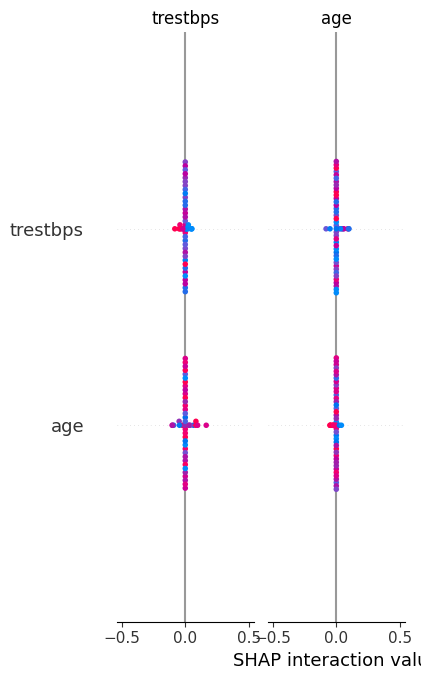

In [ ]:
if shap is not None:
    # Prepare a clean dataframe for SHAP
    X_shap = X_test.copy()
    final_estimator = best_pipe.named_steps['classifier']

    # Get feature names after preprocessing
    num_features = num_cols
    cat_ohe = best_pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = list(cat_ohe.get_feature_names_out(cat_cols))
    feature_names = num_features + cat_feature_names

    if hasattr(final_estimator, 'feature_importances_'):
        # ---- TreeExplainer (RandomForest / XGBoost) ----
        explainer = shap.TreeExplainer(final_estimator, feature_perturbation='tree_path_dependent')
        transformed_X_test = best_pipe.named_steps['preprocessor'].transform(X_test)
        shap_values = explainer.shap_values(transformed_X_test)

        try:
            sv = shap_values[1] if isinstance(shap_values, list) else shap_values
            shap.summary_plot(sv, transformed_X_test, feature_names=feature_names, plot_type='bar')
        except Exception as e:
            print('Could not produce SHAP bar plot:', e)

        # Waterfall for one example
        try:
            idx = 0
            if isinstance(sv, np.ndarray):
                shap.plots._waterfall.waterfall_legacy(explainer.expected_value, sv[idx], feature_names=feature_names)
        except Exception:
            pass

    else:
        # ---- KernelExplainer (Logistic Regression, etc.) ----
        print('Using KernelExplainer (may be slow). Taking a small background sample...')

        background = X_train.sample(n=min(50, X_train.shape[0]), random_state=42)
        background_processed = best_pipe.named_steps['preprocessor'].transform(background)
        X_shap_proc = best_pipe.named_steps['preprocessor'].transform(X_shap)

        def predict_fn(x):
            return best_pipe.named_steps['classifier'].predict_proba(x)

        try:
            kernel_explainer = shap.KernelExplainer(predict_fn, background_processed)
            shap_values = kernel_explainer.shap_values(X_shap_proc[:50])  # limit for speed
            sv = shap_values[1] if isinstance(shap_values, list) else shap_values
            shap.summary_plot(sv, X_shap_proc[:50], feature_names=feature_names, plot_type='bar')
        except Exception as e:
            print('KernelExplainer failed or too slow:', e)


# 10) Save artifacts & reproducibility

In [ ]:
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)

# Save best pipeline
joblib.dump(best_pipe, artifacts_dir / f'best_pipeline_{best_model_name}.joblib')
print('Saved best pipeline to', artifacts_dir / f'best_pipeline_{best_model_name}.joblib')

# Save a CSV of test predictions for review
results_df = X_test.copy()
results_df['y_true'] = y_test.values
results_df['y_pred'] = y_pred
results_df['y_proba'] = y_proba
results_df.to_csv(artifacts_dir / 'test_predictions.csv', index=False)
print('Saved test predictions to artifacts/test_predictions.csv')


Saved best pipeline to artifacts/best_pipeline_logreg.joblib
Saved test predictions to artifacts/test_predictions.csv


# 11) Conclusion & interview talking points

- **Problem**: binary classification (heart disease yes/no)
- **Approach**: clean preprocessing with `ColumnTransformer`, model comparison with cross-validation, and robust evaluation using ROC/AUC and PR curves.
- **Explainability**: SHAP (TreeExplainer) for global and local interpretation — discussed important features and provided force/waterfall plots for sample predictions.
- **Production considerations**: data drift monitoring, model calibration, privacy, and clinical validation are critical next steps.

# **What to mention in an interview**:
1. Why you chose the preprocessing steps (median imputation, standard scaling for continuous variables, one-hot for categorical).
2. Why stratified splitting and cross-validation were used.
3. The metrics you used and why (ROC AUC for ranking, precision/recall for class imbalance, calibration for probabilistic outputs in healthcare).
4. How explainability (SHAP) supports trust with clinicians.
5. Limitations and future work (more data, external validation, bias checks, calibration, model monitoring).
